# Special loss function

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.modules.loss import _Loss
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import wandb

import utils

In [2]:
plt.style.use('bmh')

In [3]:
rng = np.random.default_rng(2)

if torch.cuda.is_available():
    DEVICE = 'cuda'
    accelerator='gpu'
else:
    DEVICE = 'cpu'
    accelerator='cpu'

## Training and test data

### Create synthetic data

In [4]:
rng = np.random.default_rng(0)

N_SAMPLES = 5000

# Features randomly distributed
xvals = np.sort(rng.random(N_SAMPLES))

# Symmetric noise
envelope = 0.25 * np.abs(np.cos(xvals * 1.75 * np.pi))
noise = envelope * rng.normal(loc=0, scale=1, size=N_SAMPLES)
# Labels
meanvals = 2 * xvals + 0.5 * np.sin(3 * xvals * np.pi) + 1

# meanvals = np.zeros(N_SAMPLES)
yvals = meanvals + noise

Let's try standardizing values to see if that helps training:

In [5]:
x_scaler = dict(mean=xvals.mean(), std=xvals.std())
y_scaler = dict(mean=yvals.mean(), std=yvals.std())

In [6]:
def standardize(values, scaler):
    return (values - scaler['mean']) / scaler['std']

def unstandardize(values, scaler):
    return scaler['mean'] + scaler['std'] * values

In [7]:
xvals = standardize(xvals, x_scaler)
yvals = standardize(yvals, y_scaler)
meanvals = standardize(meanvals, y_scaler)
noise = noise / y_scaler['std']
envelope = envelope / y_scaler['std']

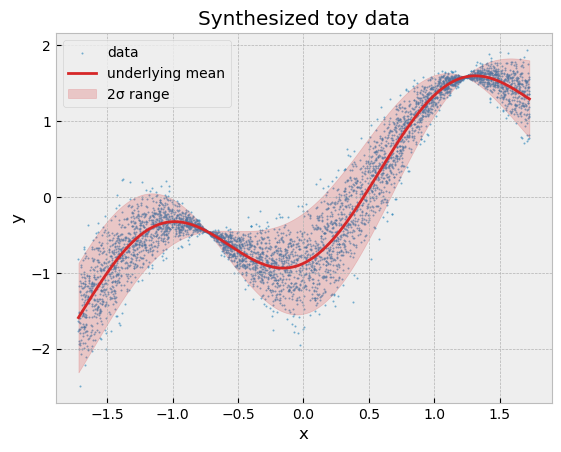

In [8]:
fig, ax = plt.subplots()
ax.scatter(xvals, yvals, s=1, alpha=0.5, label='data')
ax.set(xlabel='x', ylabel='y', title='Synthesized toy data');
ax.plot(xvals, meanvals, color='tab:red', label='underlying mean')
ax.fill_between(
    xvals, meanvals + 2*envelope, meanvals - 2*envelope, alpha=0.2,
    color='tab:red', label='2\u03C3 range'
)
ax.legend()

### Split into training and testing data

In [9]:
frac = 0.8
xvals = xvals.reshape(-1,1)
yvals = yvals.reshape(-1,1)
x_train, x_test, y_train, y_test = train_test_split(xvals, yvals, train_size=frac, random_state=0)

In [10]:
# Sort values for plotting ease later
train_sort_indices = np.argsort(x_train, axis=0).squeeze()
x_train = x_train[train_sort_indices]
y_train = y_train[train_sort_indices]

test_sort_indices = np.argsort(x_test, axis=0).squeeze()
x_test = x_test[test_sort_indices]
y_test = y_test[test_sort_indices]

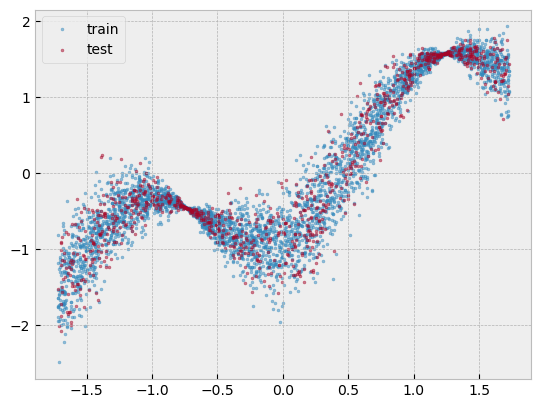

In [11]:
fig, ax = plt.subplots()

ax.scatter(x_train, y_train, s=4, alpha=0.5, label='train')
ax.scatter(x_test, y_test, s=4, alpha=0.5, label='test')
ax.legend();

### Create Tensors

In [12]:
x_train = torch.from_numpy(x_train).to(torch.float32)
y_train = torch.from_numpy(y_train).to(torch.float32)
x_test = torch.from_numpy(x_test).to(torch.float32)
y_test = torch.from_numpy(y_test).to(torch.float32)

In [13]:
if torch.cuda.is_available():
    print('Using CUDA')
    x_train = x_train.to('cuda')
    y_train = y_train.to('cuda')
    x_test = x_test.to('cuda')
    y_test = y_test.to('cuda')
else:
    print('CUDA not available')

x_train.device

CUDA not available


device(type='cpu')

### Create Dataset

In [14]:
train_ds = utils.ToyDataset(x_train, y_train)
test_ds = utils.ToyDataset(x_test, y_test)

### Create DataLoader

In [15]:
batch_size = 32

In [16]:
# Create dataloaders
train_dataloader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
)

test_dataloader = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False,
)

# Create ANN with regular Gaussian negative likelihood loss

In [17]:
configs = dict(
    network_architecture=[10, 10],
    lr=1e-3,
    optimizer='Adam',
    loss_func='GaussianNLLLoss',
    l2=0.0,
    epochs=1000,
    early_stopping=True,
    patience=50,
    std_switch=False,
    batch_size=batch_size,
    seed=0
)

In [18]:
n_inputs = 1
model = utils.ANN(n_inputs, configs)

Global seed set to 0


## Create trainer

### Create callbacks

In [19]:
def get_callbacks(configs):
    callbacks = []
    if configs['std_switch']:
        monitor = 'val/GaussianNLL'
        switch_callback = utils.LogLikelihoodSwitch(
            monitor=monitor,
            patience=configs['patience'],
            mode='min'
        )
        callbacks.append(switch_callback)
        
    if configs['early_stopping']:
        monitor = 'val/GaussianNLL'        
        early_stop_callback = pl.callbacks.EarlyStopping(
            monitor=monitor,
            patience=configs['patience'] + 1, 
            mode='min'
        )
        callbacks.append(early_stop_callback)
    return callbacks

callbacks = get_callbacks(configs)

In [20]:
callbacks

### Logger

In [21]:
name = 'control'
logger = pl.loggers.CSVLogger('logger', name=name)

### Build trainer

In [22]:
trainer = pl.Trainer(
    logger=logger,
    accelerator=accelerator,
    max_epochs=configs['epochs'],
    callbacks=callbacks,
    enable_progress_bar=False,
    deterministic=True
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/andrewbrettin/miniforge3/envs/datascience/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


## Training loop

In [23]:
%%time
trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=test_dataloader
)


  | Name    | Type            | Params
--------------------------------------------
0 | stack   | Sequential      | 152   
1 | loss_fn | GaussianNLLLoss | 0     
--------------------------------------------
152       Trainable params
0         Non-trainable params
152       Total params
0.001     Total estimated model params size (MB)
/Users/andrewbrettin/miniforge3/envs/datascience/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/andrewbrettin/miniforge3/envs/datascience/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bo

CPU times: user 1min 16s, sys: 798 ms, total: 1min 16s
Wall time: 1min 17s


## Analysis

In [24]:
# Set model to evaluation mode
model.eval()

ANN(
  (stack): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=2, bias=True)
  )
  (loss_fn): GaussianNLLLoss()
)

In [25]:
model(next(iter(train_dataloader))[0].float())[0:5,:]

tensor([[-0.8341, -1.9033],
        [-0.9174, -2.6921],
        [ 1.4640, -3.2784],
        [-0.8447, -1.9645],
        [-0.3648, -4.8463]], grad_fn=<SliceBackward0>)

In [26]:
metrics = pd.read_csv('logger/control/version_1/metrics.csv')

# Take average over each epoch
df = metrics.groupby('epoch').mean()
df.tail()

,val/GaussianNLL,val/MSE,step,train/GaussianNLL,train/MSE
epoch,,,,,
803,-1.205872,0.065966,100499.0,-1.221394,0.059523
804,-1.214915,0.066085,100624.0,-1.222898,0.059584
805,-1.232223,0.065797,100749.0,-1.210570,0.059707
806,-1.211120,0.065911,100874.0,-1.218946,0.059516
807,-1.233277,0.065929,100999.0,-1.217396,0.059676


In [27]:
epochs = df.index
train_loss = df['train/GaussianNLL']
val_loss = df['val/GaussianNLL']

train_mse = df['train/MSE']
val_mse = df['val/MSE']

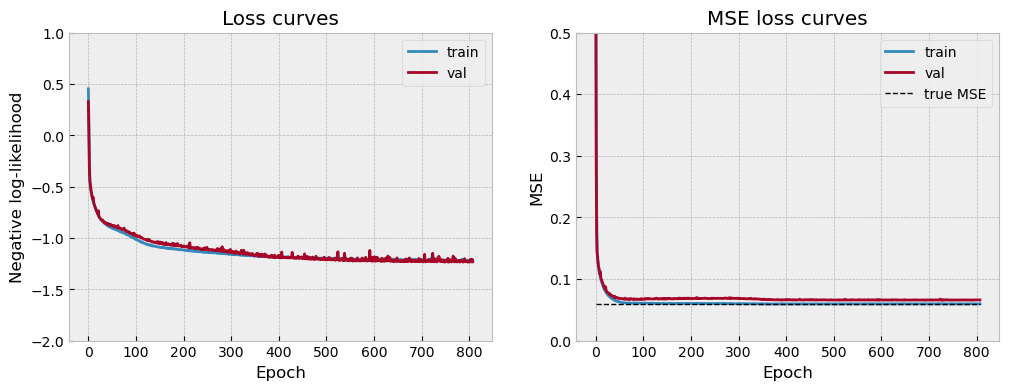

In [28]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4))
axes[0].plot(epochs, train_loss, label='train');
axes[0].plot(epochs, val_loss, label='val');
axes[0].set(
    title='Loss curves',
    xlabel='Epoch',
    ylabel='Negative log-likelihood',
    ylim=(-2,1)
)
axes[0].legend();
axes[1].plot(epochs, train_mse, label='train');
axes[1].plot(epochs, val_mse, label='val');

mse_true = np.mean(noise**2)
axes[1].plot(epochs, mse_true*np.ones_like(epochs), 
             color='k', lw=1, ls='--', label='true MSE')

axes[1].set(
    title='MSE loss curves',
    xlabel='Epoch',
    ylabel='MSE',
    ylim=(0, 0.5)
)
axes[1].legend()

In [29]:
x_pred = x_test.cpu().squeeze().numpy()
y_pred = model(x_test.float()).cpu().detach().numpy().squeeze()

indices = x_test.flatten().numpy().argsort()
x_pred = x_pred[indices]
y_pred = y_pred[indices]

y_pred_mean = y_pred[:, 0]
y_pred_std = np.sqrt(np.exp(y_pred[:, 1]))

y_pred[0:5,:]

array([[-1.510492 , -1.6174359],
       [-1.5046488, -1.6247945],
       [-1.4750843, -1.6620269],
       [-1.473525 , -1.6639905],
       [-1.4718183, -1.6661398]], dtype=float32)

[Text(0.5, 1.0, 'Distribution of true amplitudes'), (0.0, 0.5)]

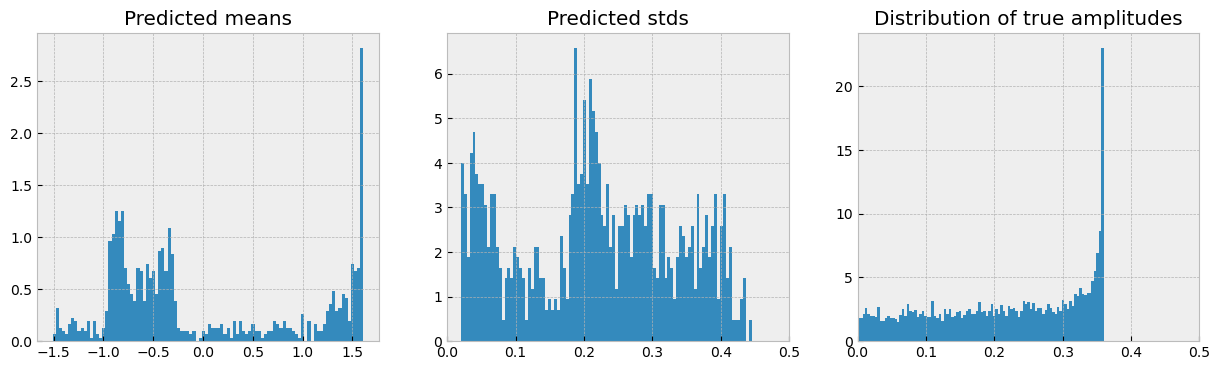

In [30]:
# Histogram of predicted values
fig, axes = plt.subplots(ncols=3, figsize=(15,4))
axes[0].hist(y_pred_mean, bins=100, density=True);
axes[1].hist(y_pred_std, bins=100, density=True);
axes[2].hist(envelope, bins=100, density=True);

axes[0].set(title='Predicted means')
axes[1].set(title='Predicted stds', xlim=(0,0.5))
axes[2].set(title='Distribution of true amplitudes', xlim=(0,0.5))

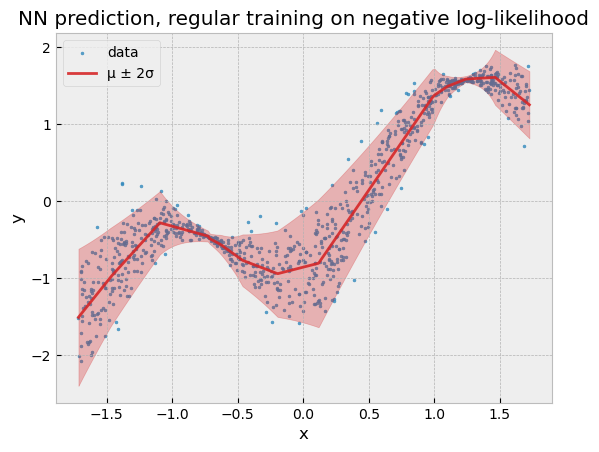

In [31]:
fig, ax = plt.subplots()

ax.scatter(x_test, y_test, s=4, alpha=0.8, label='data');
ax.plot(x_pred, y_pred_mean, alpha=0.9, color='tab:red', label='\u03BC \u00B1 2\u03C3');
ax.fill_between(x_pred, y_pred_mean + 2*y_pred_std, y_pred_mean - 2*y_pred_std,
                color='tab:red', alpha=0.3);

ax.set(
    title=r'NN prediction, regular training on negative log-likelihood',
    xlabel='x',
    ylabel='y'
);
ax.legend(loc='upper left');

# Alternative version: Freezing std until mean is trained, and then training on std

In [32]:
configs = dict(
    network_architecture=[10, 10],
    lr=1e-3,
    optimizer='Adam',
    loss_func='GaussianNLLLoss',
    l2=0.0,
    epochs=1000,
    early_stopping=True,
    patience=50,
    std_switch=True,
    batch_size=batch_size,
    seed=0
)

In [33]:
n_inputs = 1
model = utils.ANN(n_inputs, configs)

Global seed set to 0


## Create trainer

### Create callbacks

In [34]:
def get_callbacks(configs):
    callbacks = []
    if configs['std_switch']:
        monitor = 'val/GaussianNLL'
        switch_callback = utils.LogLikelihoodSwitch(
            monitor=monitor,
            patience=configs['patience'],
            mode='min'
        )
        callbacks.append(switch_callback)
        
    if configs['early_stopping']:
        monitor = 'val/GaussianNLL'        
        early_stop_callback = pl.callbacks.EarlyStopping(
            monitor=monitor,
            patience=configs['patience'] + 1, 
            mode='min'
        )
        callbacks.append(early_stop_callback)
    return callbacks

callbacks = get_callbacks(configs)

In [35]:
callbacks

### Logger

In [36]:
name = 'switched'
logger = pl.loggers.CSVLogger('logger', name=name)

### Build trainer

In [37]:
trainer = pl.Trainer(
    logger=logger,
    accelerator=accelerator,
    max_epochs=configs['epochs'],
    callbacks=callbacks,
    enable_progress_bar=False,
    deterministic=True
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/andrewbrettin/miniforge3/envs/datascience/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


## Training loop

In [38]:
%%time
trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=test_dataloader
)


  | Name    | Type            | Params
--------------------------------------------
0 | stack   | Sequential      | 152   
1 | loss_fn | GaussianNLLLoss | 0     
--------------------------------------------
152       Trainable params
0         Non-trainable params
152       Total params
0.001     Total estimated model params size (MB)
/Users/andrewbrettin/miniforge3/envs/datascience/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/andrewbrettin/miniforge3/envs/datascience/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bo

Switching training to train on mu and sigma (epoch 148)
CPU times: user 1min 15s, sys: 750 ms, total: 1min 15s
Wall time: 1min 15s


## Analysis

In [39]:
# Set model to evaluation mode
model.eval()

ANN(
  (stack): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=2, bias=True)
  )
  (loss_fn): GaussianNLLLoss()
)

In [40]:
model(next(iter(train_dataloader))[0].float())[0:5,:]

tensor([[ 1.5869, -5.9798],
        [ 0.5590, -2.4923],
        [-0.8473, -1.8868],
        [-0.3564, -5.2445],
        [-0.8604, -2.5077]], grad_fn=<SliceBackward0>)

In [41]:
metrics = pd.read_csv('logger/switched/version_1/metrics.csv')

# Take average over each epoch
df = metrics.groupby('epoch').mean()
df.tail()

,val/GaussianNLL,val/MSE,step,train/GaussianNLL,train/MSE
epoch,,,,,
783,-1.195273,0.066032,97999.0,-1.198205,0.059711
784,-1.200845,0.065774,98124.0,-1.200290,0.059689
785,-1.200622,0.066038,98249.0,-1.198934,0.059380
786,-1.199562,0.065963,98374.0,-1.200339,0.059688
787,-1.200963,0.065890,98499.0,-1.198577,0.059499


In [42]:
epochs = df.index
train_loss = df['train/GaussianNLL']
val_loss = df['val/GaussianNLL']

train_mse = df['train/MSE']
val_mse = df['val/MSE']

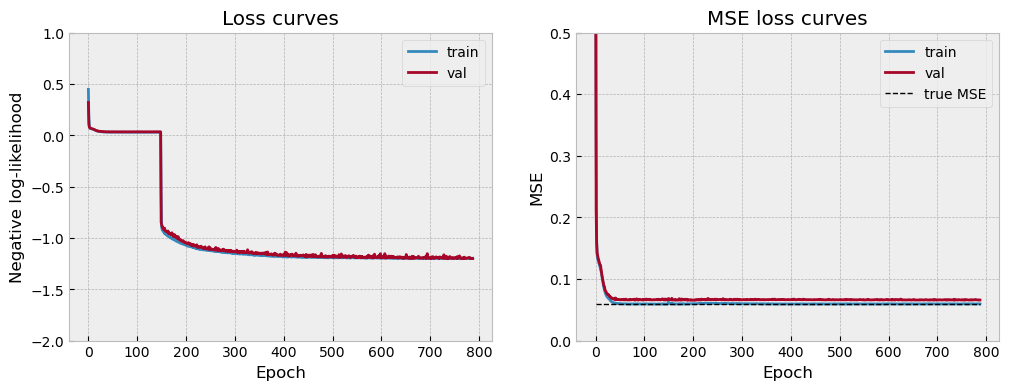

In [43]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4))
axes[0].plot(epochs, train_loss, label='train');
axes[0].plot(epochs, val_loss, label='val');
axes[0].set(
    title='Loss curves',
    xlabel='Epoch',
    ylabel='Negative log-likelihood',
    ylim=(-2,1)
)
axes[0].legend();
axes[1].plot(epochs, train_mse, label='train');
axes[1].plot(epochs, val_mse, label='val');

mse_true = np.mean(noise**2)
axes[1].plot(epochs, mse_true*np.ones_like(epochs), 
             color='k', lw=1, ls='--', label='true MSE')

axes[1].set(
    title='MSE loss curves',
    xlabel='Epoch',
    ylabel='MSE',
    ylim=(0, 0.5)
)
axes[1].legend()

In [44]:
x_pred = x_test.cpu().squeeze().numpy()
y_pred = model(x_test.float()).cpu().detach().numpy().squeeze()

indices = x_test.flatten().numpy().argsort()
x_pred = x_pred[indices]
y_pred = y_pred[indices]

y_pred_mean = y_pred[:, 0]
y_pred_std = np.sqrt(np.exp(y_pred[:, 1]))

y_pred[0:5,:]

array([[-1.4321879, -2.0428526],
       [-1.4268917, -2.0471594],
       [-1.4000926, -2.0689497],
       [-1.3986793, -2.070097 ],
       [-1.3971324, -2.0713575]], dtype=float32)

[Text(0.5, 1.0, 'Distribution of true amplitudes'), (0.0, 0.5)]

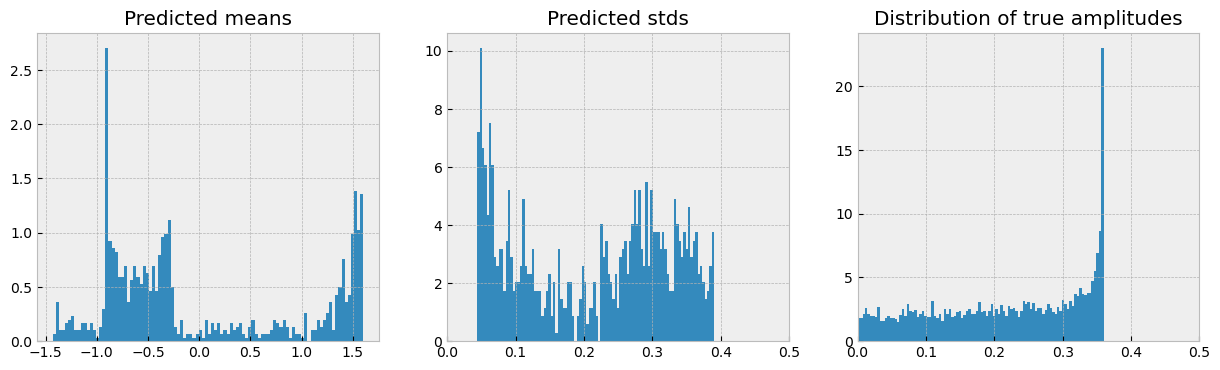

In [45]:
# Histogram of predicted values
fig, axes = plt.subplots(ncols=3, figsize=(15,4))
axes[0].hist(y_pred_mean, bins=100, density=True);
axes[1].hist(y_pred_std, bins=100, density=True);
axes[2].hist(envelope, bins=100, density=True);

axes[0].set(title='Predicted means')
axes[1].set(title='Predicted stds', xlim=(0,0.5))
axes[2].set(title='Distribution of true amplitudes', xlim=(0,0.5))

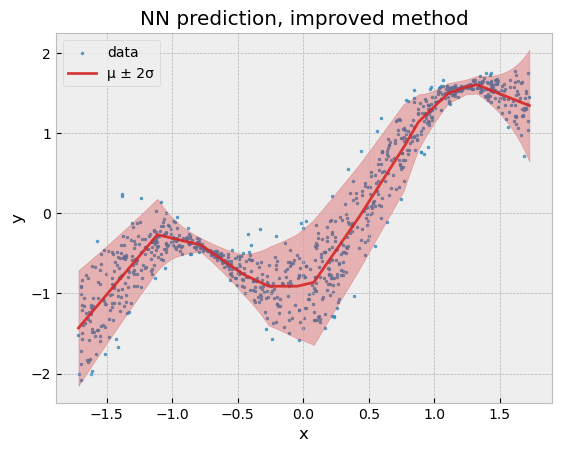

In [46]:
fig, ax = plt.subplots()

ax.scatter(x_test, y_test, s=4, alpha=0.8, label='data');
ax.plot(x_pred, y_pred_mean, alpha=0.9, color='tab:red', label='\u03BC \u00B1 2\u03C3');
ax.fill_between(x_pred, y_pred_mean + 2*y_pred_std, y_pred_mean - 2*y_pred_std,
                color='tab:red', alpha=0.3);

ax.set(
    title='NN prediction, improved method',
    xlabel='x',
    ylabel='y'
);
ax.legend(loc='upper left');

In [47]:
model.freeze_std

False

In [48]:
trainer.callbacks[0].switched_epoch

148

---